In [59]:
#!pip install keras --upgrade
#!pip install tensorflow --upgrade
#!pip install imblearn

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters
from skimage import feature
from imblearn.under_sampling import RandomUnderSampler
from skimage import feature, draw
from skimage.transform import hough_circle, hough_circle_peaks
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
import imblearn as imb
from sklearn.metrics import f1_score

In [68]:
X_train = np.load('Xtrain1.npy')
y_train = np.load('Ytrain1.npy')
X_test = np.load('Xtest1.npy')
X_train1_extra = np.load('Xtrain1_extra.npy')
# Hot Encoding the labels
train_labels = keras.utils.to_categorical(y_train,2)

## Pre-Treatment

13770
1


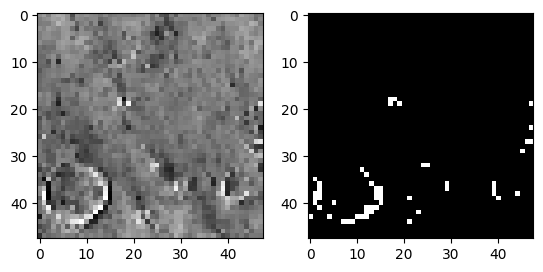

In [69]:
image_n = 600

fig, ax = plt.subplots(1,2)
im = np.reshape(X_train[image_n,:],(48,48))
new = im.copy()

threshold = 200
for i in range(im.shape[1]):
    for j in range(im.shape[0]):
        if (im[i][j] > threshold) | (im[i][j] < 30):
            new[i][j] = 255
        else:
            new[i][j] = 0

for i in range(new.shape[1]):
    for j in range(new.shape[0]):
        if new[i][j] == 256:
            if (i>0) and (j>0) and (i<new.shape[0]-1) and (j<new.shape[1]-1):
                if (new[i-1][j]==0) and (new[i+1][j]==0) and (new[i][j-1]==0) and (new[i][j+1]==0):
                    new[i][j] = 0
                
                


#m = im.imshow(im,cmap='gray')
#im = im(as_grey=True)
#new = filters.gaussian(new,sigma=0.5)  # Ajusta sigma para controlar el nivel de suavizado
#new= filters.median(new)  # Ajusta sigma para controlar el nivel de suavizado
#image_gaussian = feature.canny(im, sigma=3)  # Ajusta sigma según el nivel de detección de bordes


new[2][4] = 256.0
ax[0].imshow(im,cmap='gray')
ax[1].imshow(new, cmap='gray')
print(np.sum(new))
print(y_train[image_n])

## Data Imbalance

### The imbalance

In [71]:
print("The number of training samples with class 0 :", np.sum(y_train==0))
print("The number of training samples with class 1 :", np.sum(y_train==1))
print("The percentage of training samples with class 0 :", np.sum(y_train==0)/np.sum(y_train==1))

The number of training samples with class 0 : 1006
The number of training samples with class 1 : 1777
The percentage of training samples with class 0 : 0.566122678671919


### Random under-sampling

We remove randomly the saples from class 1 

In [72]:
#Random undersampling
rus = imb.under_sampling.RandomUnderSampler(sampling_strategy=np.sum(y_train==0)/np.sum(y_train==1))
X_train_RUS, y_train_RUS = rus.fit_resample(X_train, y_train)
X_train_RUS, X_val_RUS, y_train_RUS, y_val_RUS = train_test_split(X_train, train_labels, test_size=0.2)

### Random over-sampling

We randomly replicate data from class 0 to have the same amount as class 1.


IT CAN INCREASE OVERFITTING !!

In [74]:
ros = imb.over_sampling.RandomOverSampler(random_state=None)
X_train_ROS, y_train_ROS = ros.fit_resample(X_train, y_train)
X_train_ROS, X_val_ROS, y_train_ROS, y_val_ROS = train_test_split(X_train, train_labels, test_size=0.2)

print("The number of training samples with class 0 after ROS :", np.sum(y_train_ROS==0))
print("The number of training samples with class 1 after ROS :", np.sum(y_train_ROS==1))

The number of training samples with class 0 after ROS : 2226
The number of training samples with class 1 after ROS : 2226


### Modified SMOTE

We randomly choose a subset of the minority class and we randomly create new samples. 

We use a modified version because SMOTE is not effective on high dimensional datasets.

In [66]:
# Modified SMOTE : MSMOTE


## Machine Learning with Neural Network

In [81]:
# Neural network
model = Sequential()
model.add(Dense(16, input_dim=48*48, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.summary()

/Users/sebastian/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 16)             │        36,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,034 (144.66 KB)

 Trainable params: 37,034 (144.66 KB)

 Non-trainable params: 0 (0.00 B)

(557, 2)
Epoch 1/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5817 - loss: 7.5318 - val_accuracy: 0.6445 - val_loss: 0.6891
Epoch 2/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6413 - loss: 0.6869 - val_accuracy: 0.6445 - val_loss: 0.6817
Epoch 3/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6511 - loss: 0.6793 - val_accuracy: 0.6445 - val_loss: 0.6756
Epoch 4/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6283 - loss: 0.6764 - val_accuracy: 0.6445 - val_loss: 0.6705
Epoch 5/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6452 - loss: 0.6692 - val_accuracy: 0.6445 - val_loss: 0.6663
Epoch 6/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6385 - loss: 0.6670 - val_accuracy: 0.6445 - val_loss: 0.6632
Epoch 7/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6370 - loss: 0.6646 - val_accuracy: 0.6445 - val_loss: 0.6605
Epoch 8/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6402 - loss: 0.6612 - val_accuracy: 

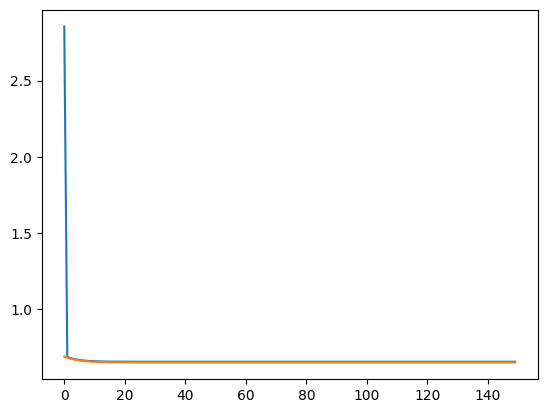

([<matplotlib.lines.Line2D at 0x7f8d60112880>], None)

In [85]:
batch_size=50
epochs=150
lr=0.001

adam = keras.optimizers.Adam(learning_rate = lr)
model.compile(optimizer = adam,
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

print(y_val_RUS.shape)
#MLP without early stopping
history = model.fit(x = X_train_RUS,y=y_train_RUS,epochs = epochs,batch_size=batch_size,validation_data = (X_val_RUS,y_val_RUS),verbose = 1)


####PLOT EVOLUTION
plt.figure(1)
plt.clf()
plt.plot(history.history['loss'], label='train'),
plt.plot(history.history['val_loss'], label='train'), plt.show()


(557, 2)
Epoch 1/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6039 - loss: 0.7199 - val_accuracy: 0.6715 - val_loss: 0.6395
Epoch 2/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6457 - loss: 0.6618 - val_accuracy: 0.6715 - val_loss: 0.6349
Epoch 3/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6381 - loss: 0.6616 - val_accuracy: 0.6715 - val_loss: 0.6333
Epoch 4/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6417 - loss: 0.6548 - val_accuracy: 0.6715 - val_loss: 0.6333
Epoch 5/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6166 - loss: 0.6699 - val_accuracy: 0.6715 - val_loss: 0.6340
Epoch 6/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6208 - loss: 0.6656 - val_accuracy: 0.6715 - val_loss: 0.6347
Epoch 7/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6158 - loss: 0.6679 - val_accuracy: 0.6715 - val_loss: 0.6352
Epoch 8/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6345 - loss: 0.6566 - val_accuracy: 0

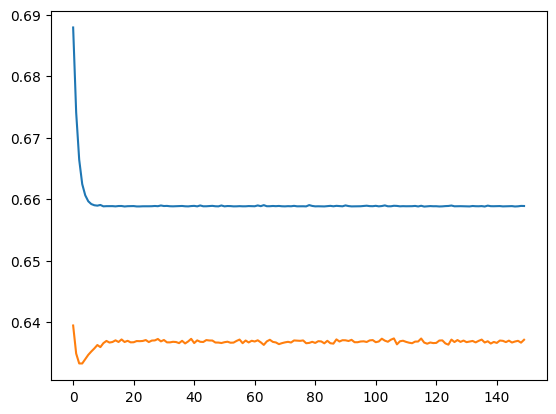

([<matplotlib.lines.Line2D at 0x7f8d639ae3a0>], None)

In [86]:
batch_size=50
epochs=150
lr=0.001

adam = keras.optimizers.Adam(learning_rate = lr)
model.compile(optimizer = adam,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

print(y_val_RUS.shape)
#MLP without early stopping
history = model.fit(x = X_train_ROS,y=y_train_ROS,epochs = epochs,batch_size=batch_size,validation_data = (X_val_ROS,y_val_ROS),verbose = 1)


####PLOT EVOLUTION
plt.figure(1)
plt.clf()
plt.plot(history.history['loss'], label='train'),
plt.plot(history.history['val_loss'], label='train'), plt.show()


In [88]:
# Prédictions après l'entraînement
y_pred_RUS = model.predict(X_val_RUS)
y_pred_RUS = (y_pred_RUS > 0.5).astype("int32")

# Calcul du F1-score
f1 = f1_score(y_val_RUS, y_pred, average='binary')
print("F1-score: ", f1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


ValueError: Target is multilabel-indicator but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted', 'samples'].